# Create Needle In A Haystack Visualization

Let's run through how to create the visualization for the Needle In A Hackstack Test.

At a highlevel, it's a two step process
1. Generate a pivot table based on the results
2. Use that pivot table as the basis for Google Slides (or whatever design tool ou want) custom formatting.

See the final [visualization](https://docs.google.com/presentation/d/15JEdEBjm32qBbqeYM6DK6G-3mUJd7FAJu-qEzj8IYLQ/edit?usp=sharing).
See the [overview video](https://twitter.com/GregKamradt/status/1729573848893579488) for this code.

Let's get started. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import json
import os
import glob

The assumption is that your individual test results will be saved to separate files. This is done to make concurrent requests easier.

If that isn't the case, feel free to change up the loading process below. The end result we want is a table with three columns (one row per test)
1. Context Length
2. Document Depth
3. Score Result

Change the folder location for where your results are stored. I'll use the original results folder for this test

## Load Data

In [4]:
# Path to the directory containing JSON results
model_name = 'Meta-Llama-3.1-8B-Instruct'
folder_path = '/mnt/petrelfs/tangzecheng/MyRLHF/reetrievalheaddetect/results/5-hop/Meta-Llama-3.1-8B-Instruct/'  # Replace with your folder path

# Using glob to find all json files in the directory
json_files = glob.glob(f"{folder_path}/*.json")

# List to hold the data
data = []

# Iterating through each file and extract the 3 columns we need
for file in json_files:
    with open(file, 'r') as f:
        json_data = json.load(f)
        # Extracting the required fields
        document_depth = json_data.get("depth_percent", None)
        context_length = json_data.get("context_length", None)
        score = json_data.get("score", None)
        # Appending to the list
        data.append({
            "Document Depth": tuple(document_depth),
            "Context Length": context_length,
            "Score": score
        })

# Creating a DataFrame
df = pd.DataFrame(data)

print (df.head())
print (f"You have {len(df)} rows")

              Document Depth  Context Length  Score
0  (0.0, 0.3, 0.5, 0.7, 0.8)            8000      0
1  (0.0, 0.2, 0.3, 0.6, 0.8)           64000      0
2  (0.0, 0.4, 0.5, 0.8, 0.9)           32000    100
3  (0.2, 0.3, 0.4, 0.5, 0.7)            8000      0
4  (0.0, 0.4, 0.6, 0.7, 0.9)            4000      0
You have 1260 rows


Then let's create a pivot table. If you just ran the test once, then this step isn't needed (but it can be done anyway). If you ran the rest multiple times then this will average out your scores.

## Pivot Data

In [6]:
pivot_table = pd.pivot_table(df, values='Score', index=['Document Depth', 'Context Length'], aggfunc='mean').reset_index() # This will aggregate
pivot_table = pivot_table.pivot(index="Document Depth", columns="Context Length", values="Score") # This will turn into a proper pivot
pivot_table.iloc[:5, :5]

Context Length,4000,8000,16000,32000,64000
Document Depth,,,,,
"(0.0, 0.1, 0.2, 0.3, 0.4)",100.0,0.0,0.0,0.0,100.0
"(0.0, 0.1, 0.2, 0.3, 0.5)",100.0,100.0,100.0,0.0,0.0
"(0.0, 0.1, 0.2, 0.3, 0.6)",100.0,100.0,0.0,0.0,100.0
"(0.0, 0.1, 0.2, 0.3, 0.7)",100.0,0.0,100.0,0.0,0.0
"(0.0, 0.1, 0.2, 0.3, 0.8)",100.0,0.0,100.0,0.0,0.0


## Make Visualization

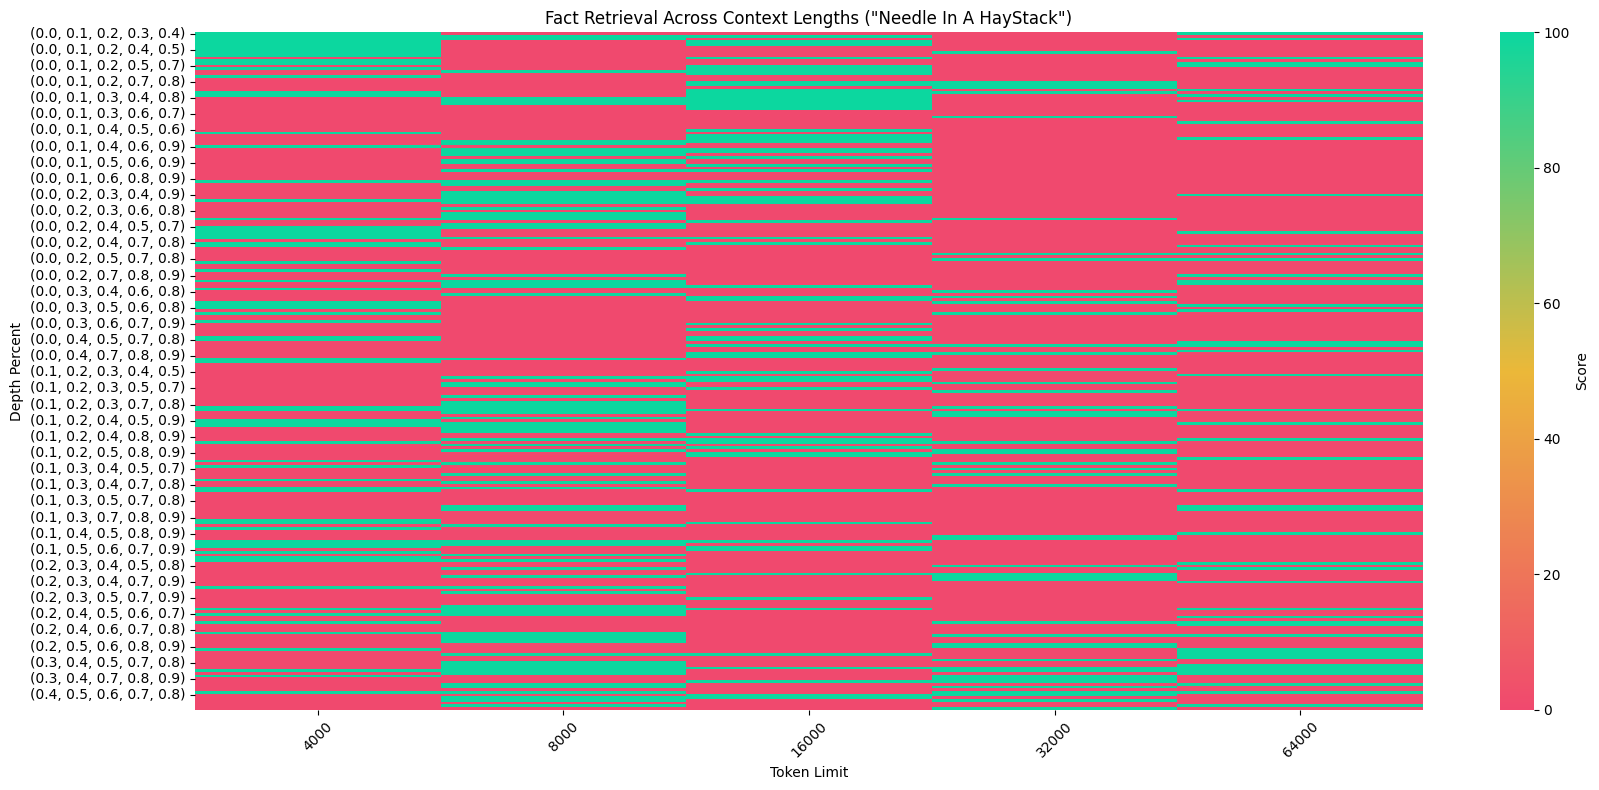

In [7]:
# Create a custom colormap. Go to https://coolors.co/ and pick cool colors
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#F0496E", "#EBB839", "#0CD79F"])

# Create the heatmap with better aesthetics
plt.figure(figsize=(17.5, 8))  # Can adjust these dimensions as needed
sns.heatmap(
    pivot_table,
    # annot=True,
    fmt="g",
    cmap=cmap,
    cbar_kws={'label': 'Score'},
    vmin=0, vmax=100)

# More aesthetics
plt.title('Fact Retrieval Across Context Lengths ("Needle In A HayStack")')  # Adds a title
plt.xlabel('Token Limit')  # X-axis label
plt.ylabel('Depth Percent')  # Y-axis label
plt.xticks(rotation=45)  # Rotates the x-axis labels to prevent overlap
plt.yticks(rotation=0)  # Ensures the y-axis labels are horizontal
plt.tight_layout()  # Fits everything neatly into the figure area

# Show the plot
plt.show()